# Introduction to Q-learning

# Motivation: Digital Quantum Simulation

Goal: replicate the dynamics of a Hamiltonian using a quantum computer


# Reinforcement learning 



<img src="agent-environment.png" width="600"/>

- "agent" learning while interacting with an environment that return numerical rewards
- goal: take actions that maximize the long-term reward
- algorithms: structured around estimating value functions

# A few examples

include my own research

# Overview
- Introduction: the multi-armed bandit (exploration vs exploitation)
- Markov decision process
- Dynamical programming
- Monte-Carlo methods
- TD methods and Q-learning

# Multi-armed bandit


<img src="tako.png" width="600"/>

## Reinforcement learning vs other types of learning:
- uses  training  information  that evaluates the  actions  taken  rather  than instructs by  giving  correct actions.

## k-armed bandit:
- choose between k options (actions)
- receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected 
- goal: maximize the expected total reward over many time steps.


## Action-value method
The value of an action is defined as $q_*(a) = \mathbb{E}(R_t | A_t = a) $

Simplest estimation of $q_*(a)$ is $Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$ : average of the rewards received for $a$.

Or iteratively: $Q(a) \leftarrow Q(a) + \alpha \left[R - Q(a)\right]$ when $a$ is selected, with $\alpha = 1/n(a)$ and $n(a)$ counts the number of times $a$ was chosen.

## Exploitation vs Exploration
At a given time, the simplest action selection rule (also called a _policy_) is
$$A_t = {\underset{a}{\operatorname{argmax}}} \, Q_t(a)$$

This is the _greedy_ policy. It exploits current knowledge.
Dilemma: apparently inferior actions might actually be better.

Simple alternative: ___$\varepsilon$-greedy___ action selection
$$ A_t = \left\{ \begin{eqnarray} &{\rm random} \qquad &{\rm with \, \, prob} \, \, \varepsilon \\ &{\underset{a}{\operatorname{argmax}}} \, Q_t(a) \qquad &{\rm else} \end{eqnarray} \right.$$

This policy is central to a lot of reinforcement learning algorithms.


### 10-armed bandit testbed
For each arm $q_*(a)$ (the mean reward) is chosen randomly according to $\mathcal{N}(0, 1)$, and the rewards follow $\mathcal{N}(q_*(a), 1)$.

<IPython.core.display.Javascript object>


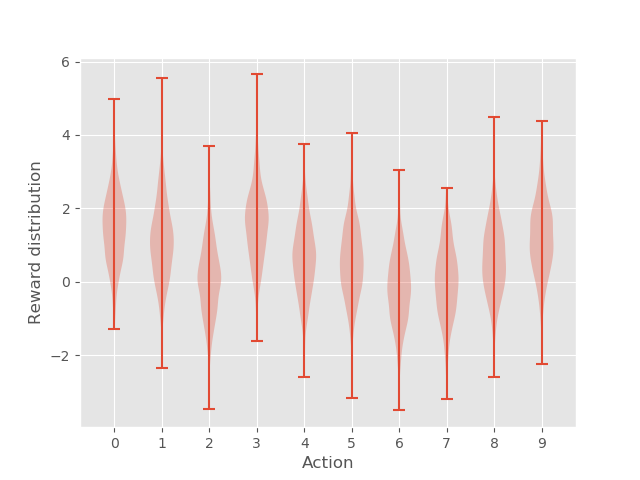

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from tqdm import trange
from time import sleep

plt.violinplot(dataset=np.random.randn(1000, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.xticks(range(1, 11), range(10))
plt.show()

In [2]:
class Bandit():
    
    def __init__(self, k, epsilon=0.0, seed=0):
        self.k = k
        self.epsilon = epsilon
        np.random.seed(seed)
        self.reset()
    
    def reset(self):
        self.time = 0
        # mean reward for each action (each arm)
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true)
        # estimation for each action
        self.q_estimation = np.zeros(self.k)
        # count for each action
        self.action_count = np.zeros(self.k, dtype=int)
        
    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(self.k))
        else:
            q_best = np.max(self.q_estimation)
            return np.random.choice(np.nonzero(self.q_estimation == q_best)[0])
        
    def step(self, action):
        self.time +=1
        # generate reward
        reward = np.random.randn() + self.q_true[action]
        self.action_count[action] += 1
        
        # incremental update (step size = 1/action_count)
        self.q_estimation[action] += (reward - self.q_estimation[action])/self.action_count[action]
        
        return reward

Simulating 4 10-arm bandits up to t=100, 200 times each.


100%|██████████| 200/200 [00:00<00:00, 857.84it/s]


<IPython.core.display.Javascript object>


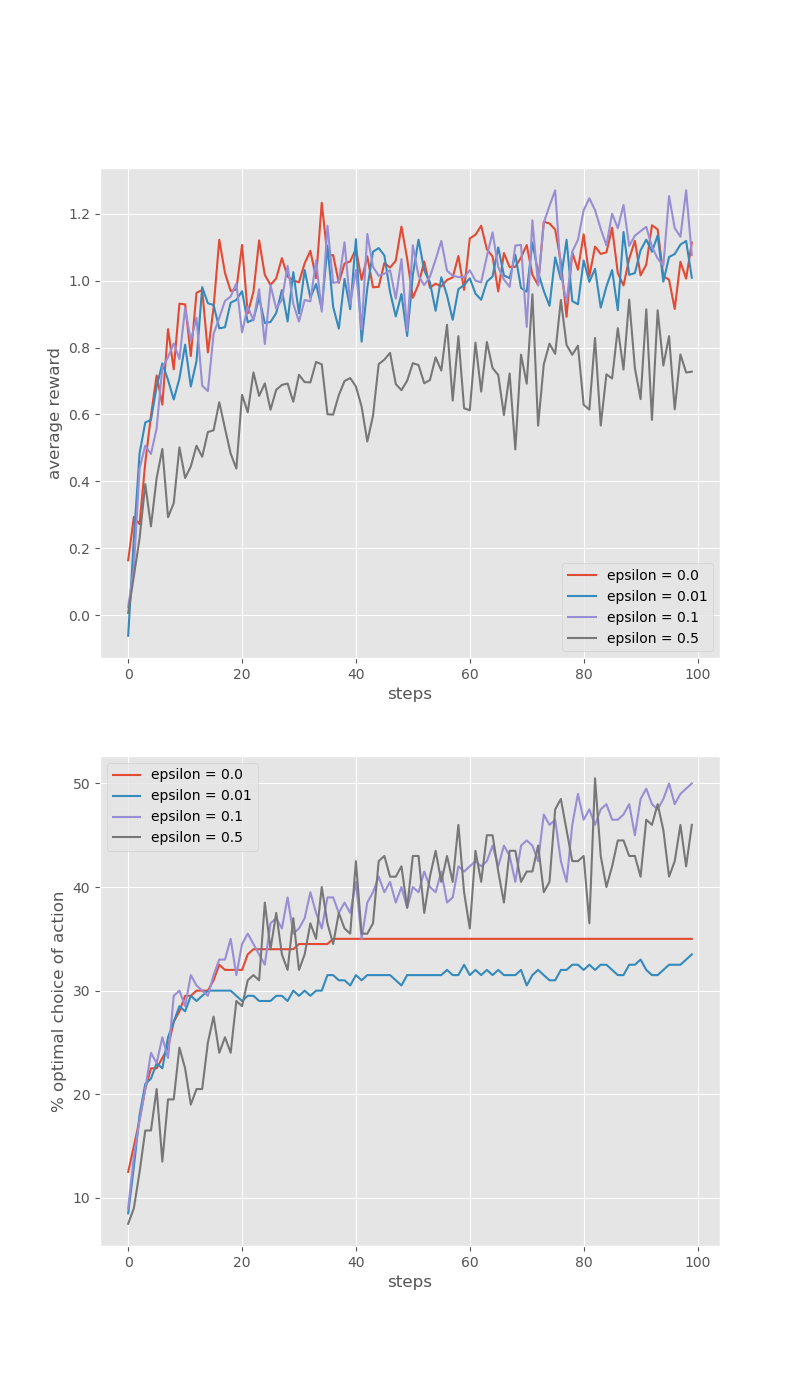

In [3]:
def simulate(n_runs, max_time, bandits):
    """n_runs (with different q_*) of all bandits up to t=max_time"""
    
    print(f"Simulating {len(bandits)} {bandits[0].k}-arm bandits up to t={max_time}, {n_runs} times each.")
    sleep(0.5)
    # track two metrics
    rewards = np.zeros((len(bandits), n_runs, max_time))
    optimal_choice_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for run in trange(n_runs):
            bandit.reset()
            for time in range(max_time):
                action = bandit.choose_action()
                reward = bandit.step(action)
                rewards[i, run, time] = reward
                if action == bandit.best_action:
                    optimal_choice_counts[i, run, time] = 1
    mean_optimal_choice_counts = optimal_choice_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_optimal_choice_counts, mean_rewards


def bandit_figure(n_runs, max_time):
    epsilons = [0., 0.01, 0.1, 0.5]
    bandits = [Bandit(k=10, epsilon=eps) for eps in epsilons]
    optimal_choice_counts, rewards = simulate(n_runs, max_time, bandits)
    
    plt.style.use('ggplot')
    fig, ax = plt.subplots(2, 1, figsize=(8, 14))
    
    for eps, rewards, counts in zip(epsilons, rewards, optimal_choice_counts):
        ax[0].plot(rewards, label=f'epsilon = {eps}')
        ax[1].plot(100*counts, label=f'epsilon = {eps}')
    ax[0].set_xlabel('steps')
    ax[0].set_ylabel('average reward')
    ax[0].legend()
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('% optimal choice of action')
    ax[1].legend()
    
bandit_figure(n_runs=200, max_time=100)

# Markov Decision Processes

- __Sequential__ decision making: state of the environment change with action
- Actions influence not only the immediate rewards, but also the subsequent states $\rightarrow$ delayed rewards

## The Agent-Environment Interface

- At each time step $t$: agent receives information about the state $S_t \in \mathcal{S}$, chooses an action $A_t \in \mathcal{A}$. One time step later, the agent receives a reward $R_{t+1} \in \mathcal{R}$ and finds itself in a new state $S_{t+1}$.

<img src="agent-environment.png" width="600"/>

- MDP + agent give rise to trajectories $$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 ... $$

 
- dynamics of the MDP: $p(s', r \, | \, s, a) = {\rm Pr}(S_t = s', R_t = r \, | \, S_{t-1} = s, A_{t-1} = a)$ (can be deterministic)

- goal: maximize the delayed rewards or _return_ $G_t$
    - episodic tasks (terminal state reached at $t=T$) $$ G_t = R_{t+1} + R_{t+2} + \dots + R_T $$
    - continuing tasks $$ G_t = R_{t+1} + \gamma R_{t+2}  +  \gamma^2 R_{t+3} + \dots $$

## Policies and Value Functions

- As for the multi-armed bandit, we want to quantify the _value_ of choosing an action $a$.
- The choice depends on the state $s$ $\rightarrow$ like a different multi-armed bandit for each state.

The policy $\pi$ of the agent defines the probability $\pi(a \,|\, s)$ that $A_t =a$ if $S_t = s$.

For a given policy $\pi$, we can define
- The __value function__ of a state $s$: $$v_{\pi}(s) = \mathbb{E}_{\pi}[G_t \, | \, S_t = s] = \mathbb{E}_{\pi}[\sum_{i=0}^{\infty} \gamma^i R_{t+1+i} \, | \, S_t = s]$$

- The __action-value function__ (or _quality_ function) of an action $a$ given a state $s$: $$q_{\pi}(s, a) = \mathbb{E}_{\pi}[G_t \, | \, S_t = s, A_t = a] = \mathbb{E}_{\pi}[\sum_{i=0}^{\infty} \gamma^i R_{t+1+i} \, | \, S_t = s, A_t = a]$$


The value functions both satisfy a recursive equation, a __Bellman equation__

$$v_{\pi}(s) = \mathbb{E}_{\pi}[R_{t+1} + \gamma G_{t+1} \, | \, S_t = s] = \sum_a \pi(a \,|\, s) \sum_{s', r}p(s', r \,|\, s, a) \left[r + \gamma v_{\pi}(s')\right] $$


$$q_{\pi}(s) = \mathbb{E}_{\pi}[R_{t+1} + \gamma G_{t+1} \, | \, S_t = s, A_t = a] =  \sum_{s', r}p(s', r \,|\, s, a)\sum_{a'} \pi(a' \,|\, s') \left[r + \gamma q_{\pi}(s', a')\right] $$
### optimal policy

Solving a reinforcement learning task $\approx$  finding a policy that achieves high rewards over the long run

An _optimal policy_ $\pi_*$ satisfies $v_{\pi_*}(s) \ge v_{\pi}(s)$ for all $s \in \mathcal{S}$ and all $\pi$. The __optimal value functions__ are then uniquely defined:

$$v_*(s) = \max_{\pi} v_{\pi}(s) \qquad \qquad q_*(s, a) = \max_{\pi} q_{\pi}(s, a)$$

which are related by

$$q_*(s, a) = \mathbb{E}[R_{t+1} + \gamma v_*(S_{t+1}) \, |\, S_t = s, A_t = a] \qquad v_*(s) = \max_a q_*(s, a)$$


Then, the greedy policy $\pi(a \,|\, s) = 1$ for $ a= {\underset{a'}{\operatorname{argmax}}} \, q_*(s, a')$ is an optimal policy.

### Bellman optimality equations

- Central to most RL algorithm.
- Written without explicit reference to any policy.

$$q_*(s, a) = \sum_{s', r'} p(s', r \,|\, s, a) \left[r + \gamma \max_{a'} q_*(s', a')\right] \qquad
v_*(s) = \max_{a}\sum_{s', r'} p(s', r \,|\, s, a) \left[r + \gamma v_*(s')\right]$$

For deterministic environments:

$$q_*(S_t, A_t) = R_{t+1} + \gamma \max_{a'} q_*(S_{t+1}, a') \qquad
v_*(S_t) = \max_{A_t}\left[R_{t+1} + \gamma v_*(S_{t+1})\right]$$

# Dynamic Programming

Key idea: use of value functions to organize and structure the search for good policies.

Two main steps:
- Policy __evaluation__ (or prediction problem):
    for a fixed policy $\pi$, compute an approximation of the value function $v_{\pi}(s)$ iteratively.

- Policy __improvement__:
    improve the policy $\pi \rightarrow \pi'$ such that $v_{\pi'}(s) \ge v_{\pi}(s)$ for all $s$.

## policy evaluation

Simple algorithm to evaluate $v_{\pi}(s)$:
1. Start with an arbitrary value function $v_0$ (e.g. all 0's)
2. Use the Bellman equation as an update rule: $$v_{k+1}(s) = \mathbb{E}_{\pi} \left[R_{t+1} + \gamma v_{k}(S_{t+1}) \,|\, S_t = s\right]$$

$\rightarrow$ $v_{\pi}$ is a fixed point for this update rule.

### Example: 4 x 4 gridworld with equiprobable random policy (deterministic transitions)


<img src="gridworld.png" width="600"/>

In [129]:
plt.style.use('default')

GRID_ACTIONS = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
class Gridworld():
    
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.actions = GRID_ACTIONS
        self.prob = 0.25
        
    def step(self, state, action):
        """return a tuple (next_state, reward)"""
        if self.is_terminal(state):
            return state, 0
        
        next_state = state + action
        i, j = next_state
        if i < 0 or i >= self.length or j < 0 or j >= self.width:
            next_state = state
        reward = -1
        if self.is_terminal(next_state):
            reward = 0
        return next_state, reward
        
        
    def is_terminal(self, state):
        i, j = state
        return (i == 0 and j == 0) or (i == self.length-1 and j == self.width-1)
    
    
    def compute_value_function(self, discount_rate=1.0, n_steps=None):
        """Computer the value function after n_steps iterations or until it converges"""
        if n_steps is None:
            n_steps = float('Inf')
        step = 0
        value_function = np.zeros((self.length, self.width))
        while step < n_steps:
            old_value_function = value_function.copy()
            for i in range(self.length):
                for j in range(self.width):
                    state = np.array([i, j])
                    value = 0
                    for action in self.actions:
                        (next_i, next_j), reward = self.step(state, action)
                        value += self.prob * (reward + discount_rate * old_value_function[next_i, next_j])
                    value_function[i, j] = value

            max_diff = abs(old_value_function - value_function).max()
            if max_diff < 1e-4:
                break
            step += 1
        return value_function, step
    
    def greedy_actions(self, value_function, discount_rate=1.0):
        """return a dictionary containing the lists of greedy actions given a value function v(s)"""
        greedy_actions_dict = {}
        for i in range(self.length):
            for j in range(self.width):
                state = np.array([i, j])
                if self.is_terminal(state):
                    greedy_actions_dict[(i, j)] = []
                    continue
                qs = []
                for action in self.actions:
                    (next_i, next_j), reward = self.step(state, action)
                    qs.append(discount_rate * value_function[next_i, next_j] + reward)
                greedy_actions_dict[(i, j)] = [a for a, q in enumerate(qs) if abs(q-max(qs))<1e-2]
        return greedy_actions_dict
    
    
def draw_grid(matrix, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.matshow(matrix, cmap='Blues_r')
    for (i, j), value in np.ndenumerate(matrix):
        ax.text(j, i, f'{value:0.1f}', ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    ax.set_xticks(np.arange(-0.5, j+1, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, i+1, 1), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    return im

<IPython.core.display.Javascript object>


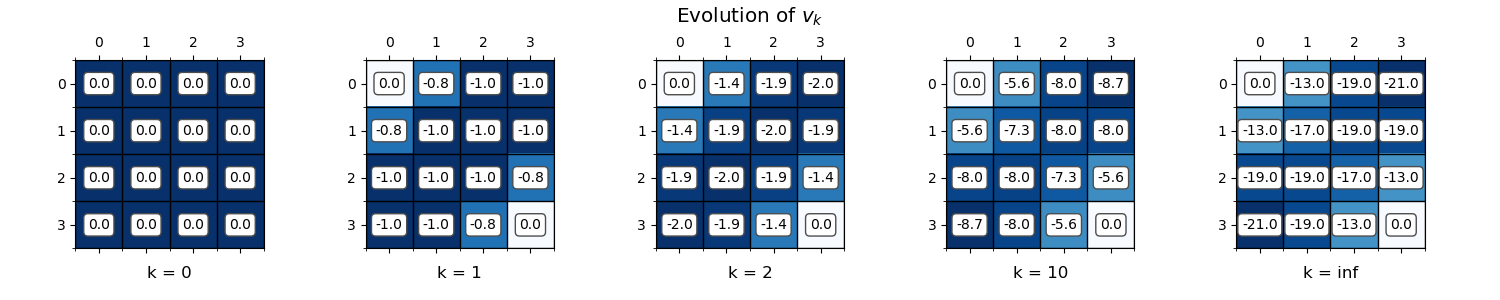

In [130]:
grid = Gridworld(4, 4)
n_steps = [0, 1, 2, 10, float('Inf')]
n_plots = len(n_steps)
value_functions = [grid.compute_value_function(n_steps=k)[0] for k in n_steps]
fig, axes = plt.subplots(1, n_plots, figsize=(3*n_plots, 3))
for value_function, ax, k in zip(value_functions, axes, n_steps):
    im = draw_grid(value_function, ax)
    # im.set_clim(vmin=-20, vmax=0)
    ax.set_title(f'k = {k}', y=-0.2)
    plt.tight_layout()
    
st = fig.suptitle(r"Evolution of $v_k$", fontsize="x-large")
fig.subplots_adjust(top=0.8)
    

## Policy improvement

Computing the value function helps us find better policies.

- A new policy can be found by choosing good actions, i.e. satisfying $q_{\pi}(s, a) \ge v_{\pi}(s)$
(recall that $q_{\pi}(s, a) = \mathbb{E}\left[ R_{t+1} + \gamma v_{\pi}(S_{t+1}) \,|\, S_t = s, A_t = a \right]$).
 
  
- __Policy improvement theorem__:
    For a new deterministic policy $\pi'$ (i.e. $A_t = \pi'(S_t)$)
    
    $$q_{\pi}(s, \pi'(s)) \ge v_{\pi}(s) \Rightarrow v_{\pi'}(s) \ge v_{\pi}(s)$$
    
    
- Automatically satisfied by the greedy policy: $$ \pi'(s) = {\underset{a'}{\operatorname{argmax}}}q_{\pi}(s, a') $$

- In which case: $$ v_{\pi'}(s) = \max_{a} \mathbb{E}\left[ R_{t+1} + \gamma v_{\pi}(S_{t+1}) \,|\, S_t = s, A_t = a \right] $$

If $v_{\pi'}(s) = v_{\pi}(s)$, this is the Bellman equation $\Rightarrow$ __converges to the optimal value function!__


## Policy iteration 

We thus have a algorithm to find the optimal value function:

$$ \pi_{0} \xrightarrow{\text{E}} v_{\pi_0} \xrightarrow{\text{I}} \pi_{1} \xrightarrow{\text{E}} v_{\pi_1} \xrightarrow{\text{I}} \pi_{2} \xrightarrow{\text{E}} v_{\pi_2} \xrightarrow{\text{I}} \pi_3 \xrightarrow{} \dots \xrightarrow{} v_*$$


E: __policy evaluation__ $\qquad$
I: __policy improvement__

However, each policy evaluation itself is an iterative computation $\Rightarrow$ not time efficient.
Do we need the fully converge value function for each policy?

<IPython.core.display.Javascript object>


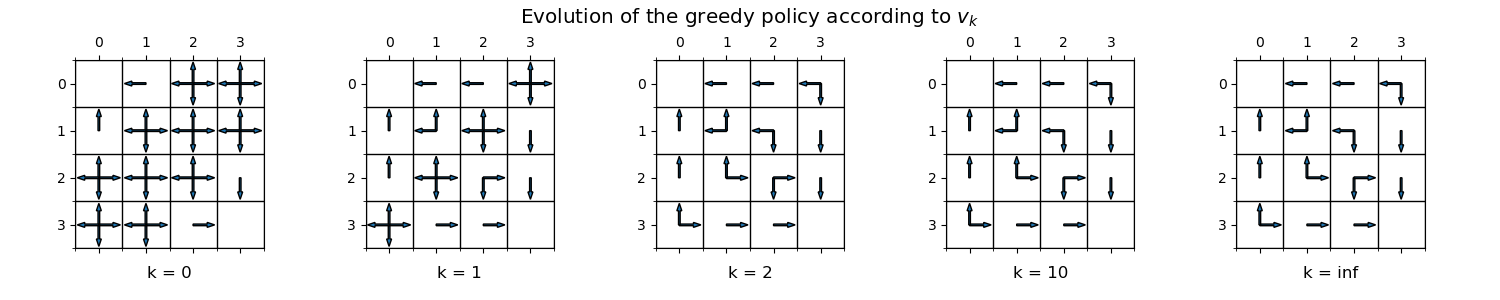

In [131]:
def draw_arrows(arrow_dict, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    indices = []
    arrows = []
    for key, actions in arrow_dict.items():
        for a in actions:
            indices.append(key)
            arrows.append(GRID_ACTIONS[a])
    y, x = zip(*indices)
    im = ax.matshow(np.zeros((max(y)+1, max(x)+1)), cmap='Greys')
    ax.set_xticks(np.arange(-0.5, max(x)+1, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, max(y)+1, 1), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    for (i, j), (di, dj) in zip(indices, arrows):
        ax.arrow(x=j, y=i, dx=0.3*dj, dy=0.3*di, width=0.035)
    return im

fig, axes = plt.subplots(1, n_plots, figsize=(3*n_plots, 3))
actions_dicts = [grid.greedy_actions(v) for v in value_functions]
for actions, k, ax in zip(actions_dicts, n_steps, axes):
    draw_arrows(actions, ax)
    ax.set_title(f'k = {k}', y=-0.2)
    plt.tight_layout()
    
fig.suptitle(r"Evolution of the greedy policy according to $v_k$", fontsize="x-large")
fig.subplots_adjust(top=0.8)

## Value iteration

As we can see, policy evaluation can be stropped early (correct greedy policy already obtained for $k=2$.)

- Special case: stop after just one sweep (one update of each state):

$$v_{k+1}(s) = \max_a \mathbb{E}\left[R_{t+1} + \gamma v_k(S_{t+1}) \,|\, S_t =s, A_t = a\right]$$

This algorithm is called __value iteration__.

It can be seen as an update using directly the Bellman optimality equation (without considering the underlying policy).

This update rule is central to algorithms like Q-learning. But one problem remain: we still assume complete knowledge of the environment (all the states). How can we learn only from _experience_?

# Monte Carlo Methods

Finally, we consider an actual reinforcement learning method.

- Optimal policy is estimated using only _experience_
    - use sequences $(S_0, A_0, R_1, S_1, A_1, \dots)$ from interaction with an environment.
     
      
- Experience divided into _episodes_ (from $t=0$ to $t=T$).
 
  
- If no model of the environment is available, it is better to directly estimate action values $q(s, a)$

$$ \pi_{0} \xrightarrow{\text{E}} q_{\pi_0} \xrightarrow{\text{I}} \pi_{1} \xrightarrow{\text{E}} q_{\pi_1} \xrightarrow{\text{I}} \pi_{2} \xrightarrow{\text{E}} q_{\pi_2} \xrightarrow{\text{I}} \pi_3 \xrightarrow{} \dots \xrightarrow{} q_*$$
 
 
- Policy evaluation is based on averaging the sample return $G_t = R_{t+1} + R_{t+2} + \dots + R_T$ for each state-action pair (s, a)
    - unlike dynamical programming, no reference to the Bellman equation

    $\rightarrow$ generalization of the bandit method (a different bandit for each state)
    
    



### Simple Monte Carlo algorithm

- Alternate between policy evaluation and policy improvement on an __episode-by-episode basis__:
 
    - __evaluation__: update sample average of $G_t$ for the pair $(s, a)$ observed during the episode. 
        - c.f. value iteration: only one step of policy evaluation is performed (instead of averaging over many episodes using the same policy)
      
    - __improvement__: $\pi_{k+1}(s) = {\underset{a}{\operatorname{argmax}}}q_{\pi_{k}}(s, a)$
    
    <img src="MC_algorithm.png" width="600"/>
    
    
In general, a Monte-Carlo step can generally be be written as
- simulate an episode under $\pi_{k}$
- at the end of an episode
$$Q(s, a) \leftarrow Q(S_t, A_t) + \alpha \left[G_t - Q(S_t, A_t)\right]$$ for all $(S_t, A_t)$ in the episode. (choice of $\alpha$ depends on the algorithm.)
- $$\pi_{k+1}(s) = {\underset{a}{\operatorname{argmax}}}Q(s, a)$$

## Back to exploration vs exploitation

- "Exploring starts" necessary so that every pair (s, a) can be experienced by the learning agent

- This is not reasonable in practice. Alternative: add __soft randomness__ in the policy (e.g. $\varepsilon$-greedy policy, c.f. the multi-armed bandit problem)

$\rightarrow$ Modify $\pi$ so that $\pi(a \, | \, s) >0$ for all $s$ and $a$.

Two approaches: _on-policy_ and _off-policy_ methods

### On-policy methods

Evaluate/improve the policy that is used to make the decision

__Compromise__: learns $q(s, a)$ not for the optimal policy, but for a near-optimal policy that still explores.



### Off-policy methods

Use two policies:
- The __target policy__: policy being learned
- The __behavior policy__: policy used to generate behavior (i.e. to choose the actions)

$\rightarrow$ only add randomness to the behavior policy.


# Temporal-Difference Learning


Novel and central idea to reinforcement learning. Most modern RL algorithms use TD learning (e.g. Q-learning!)

- Combination of __Monte Carlo__ ideas and __dynamical programming__ ideas for policy evaluation 


- Like MC methods, TD methods learn directly from raw experience without a model of the environment
    - MC: after each episode $$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[G_t - Q(S_t, A_t)\right]$$
    
- Like dynamical programming, TD methods update estimates based in part on other learned estimates
    - DP update for policy evaluation, based on the Bellman equation: $$Q(s, a) \leftarrow \mathbb{E}_{\pi}\left[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) \,|\, S_t = s, A_t = a\right]$$
    
    
MC methods need to wait for the end of each episode to determine $G_t$.
With TD methods, the value function is updated __after each time step__

- Only look one step ahead: approximate $G_t = R_{t+1} + \gamma G_{t+1} \approx R_{t+1} + \gamma Q(S_{t+1}, A_{t+1})$.
This is called a __bootstrapping method__

Basic on-policy TD update rule:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)\right] = Q(S_t, A_t) + \alpha \delta_t$$


- The TD error is defined as: $\delta_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)$
    

## Sarsa: On-policy


We have the TD update rule, but we still need to update the policy.

- In the Sarsa algorithm, a exploring policy must be used, typically the $\varepsilon$-greedy policy, for _all_ action choices
$$ A_t = \left\{ \begin{eqnarray} &{\rm random} \qquad &{\rm with \, \, prob} \, \, \varepsilon \\ &{\underset{a}{\operatorname{argmax}}} \, Q(S_t, a) \qquad &{\rm else} \end{eqnarray} \right.$$


## Q-learning: Off-policy

As mentioned before, it is sometimes good to split the _target policy_ and the _behavior policy_

The difference is subtle:

- Given a state $S_t$, the agent chooses the action $A_t$ using the __behavior policy__, which should include exploration (typically the $\varepsilon$-greedy policy)
$$ A_t = \left\{ \begin{eqnarray} &{\rm random} \qquad &{\rm with \, \, prob} \, \, \varepsilon \\ &{\underset{a}{\operatorname{argmax}}} \, Q(S_t, a) \qquad &{\rm else} \end{eqnarray} \right.$$

    and gets $S_{t+1}$ and $R_{t+1}$ from the environment.

- In order to update $Q(S_t, A_t)$, the TD error must be calculated by looking __one step ahead__:
 $$ \delta_t = Q_{\rm target} - Q(S_t, A_t) $$
 
 where $$Q_{\rm target} = R_{t+1} + \gamma Q(S_{t+1}, \pi_{\rm target}(S_{t+1}))$$ 
 obtained using the __target policy__ (without exploration):
 
 $$\pi_{\rm target}(S_{t+1}) = \underset{a}{\operatorname{argmax}} \, Q(S_t, a) $$
 
 
 
 In short, the Q-learning update rule is:
 
 - get $A_t$ using the $\varepsilon$-greedy policy from $S_t$
 
 - $$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)\right] $$
 
 

In [ ]:
## Q-learning for the 'cart pole' environment 



In [93]:
# !pip install gym
import gym
import numpy as np

class DiscreteCartPoleEnv():
    """Discrete version of the 'CartPole' environment of the openAI package gym"""
    
    def __init__(self, n_bins=(1, 1, 6, 12), max_steps=None,
                lower_bounds=(None, None, None, -np.radians(50)),
                upper_bounds=(None, None, None, np.radians(50))):
        
        self.env = gym.make('CartPole-v1')
        self.n_bins = n_bins
        self.state_action_space_shape = n_bins + (self.env.action_space.n, )
        
        self.bins = []
        for i, (n, lb, ub) in enumerate(zip(self.n_bins, lower_bounds, upper_bounds)):
            if n == 1: self.bins.append(None)
            else:
                if lb is None:
                    lb = self.env.observation_space.low[i]
                if ub is None:
                    ub = self.env.observation_space.high[i]
                self.bins.append(np.linspace(lb, ub, n+1))
            
        if max_steps is not None:
            self.env._max_episode_steps = max_steps
        self.max_steps = self.env._max_episode_steps
        
        
    def discretize(self, state):
        for i, (bin_edges, n) in enumerate(zip(self.bins, self.n_bins)):
            if n == 1:
                state[i] = 0
            else:
                # digitize returns the bin index starting from 1
                state[i] = np.digitize(state[i], bin_edges) - 1
                state[i] = min(n-1, max(0, state[i]))
        state = tuple(state.astype(int))
        return state
                
    def random_action(self):
        return self.env.action_space.sample()
    
    def step(self, action):
        new_state, reward, done, info = self.env.step(action)
        return self.discretize(new_state), reward, done, info
    
    def reset(self):
        return self.env.reset()
    
    def render(self):
        return self.env.render()

In [118]:
from collections import deque

class QLearningSolver():
    def __init__(self, env, n_episodes=1000, win_condition=195, batch_size=100, 
                 min_α=0.1, α_decay_rate=0.99,
                 min_ϵ=0.1, ϵ_decay_rate=0.99,
                 γ=1.0, seed=None):
        
        self.env = env
        
        self.n_episodes = n_episodes
        # average survival time (in number of steps) required to be considered a sucessful episode
        self.win_condition = win_condition
        if win_condition > self.env.max_steps:
            print("Warning: the win condition cannot be met.")
        # win_condition is averaged over last batch_size episodes
        self.batch_size = batch_size
     
        # learning rate (starts at 1 and decays until reaching a minimum)
        self.α_decay_rate = α_decay_rate
        self.min_α = min_α
        
        # exploration rate (starts at 1 and decays until reaching a minimum)
        self.ϵ_decay_rate = ϵ_decay_rate
        self.min_ϵ = min_ϵ
        
        # discount rate
        self.γ = γ
        
        self.Q = np.zeros(self.env.state_action_space_shape)
        
        if seed is not None:
            np.random.seed(seed)
        

    def choose_action(self, state, ϵ):
        if np.random.rand() < ϵ:
            return self.env.random_action()
        else:
            return np.argmax(self.Q[state])
        
    def update(self, state, action, reward, new_state, α):
        self.Q[state][action] += α * (reward + self.γ * np.max(self.Q[new_state]) - self.Q[state][action])

    def get_ϵ(self, t):
        return max(self.min_ϵ, self.ϵ_decay_rate**t)

    def get_α(self, t):
        return max(self.min_α, self.α_decay_rate**t)

    def run(self):
        scores = []

        for episode in range(self.n_episodes):
            state = self.env.discretize(self.env.reset())

            α = self.get_α(episode)
            ϵ = self.get_ϵ(episode)
            done = False
                   
            step = 0
            while not done:
                action = self.choose_action(state, ϵ)
                new_state, reward, done, _ = self.env.step(action)
              
                self.update(state, action, reward, new_state, α)
                state = new_state
                step += 1

            scores.append(step)
            mean_score = np.mean(scores[-min(len(scores), self.batch_size):])
            if mean_score >= self.win_condition and episode >= self.batch_size:
                print(f'Ran {episode} episodes in total. Solved after {episode - self.batch_size} episodes')
                return (episode - self.batch_size, scores)
            if episode % self.batch_size == 0 and episode != 0:
                print(f'(Episode {episode}) -- Average survival time over last'
                      f' {self.batch_size} episodes was {mean_score} steps.')

        print(f'Could not be solved after {episode} episodes')
        return (episode, scores)
    
    def render(self):
        """Render an episode using the current Q-function."""
        state = self.env.discretize(self.env.reset())
        done = False
        while not done:
            self.env.render()
            action = self.choose_action(state, ϵ=0)
            new_state, reward, done, _ = self.env.step(action)
            state = new_state
        self.env.env.close()

In [119]:
env = DiscreteCartPoleEnv(max_steps=500)
solver = QLearningSolver(env=env, win_condition=400)

In [120]:
solver.render()

(Episode 100) -- Average survival time over last 100 episodes was 49.09 steps.
(Episode 200) -- Average survival time over last 100 episodes was 346.7 steps.
Ran 219 episodes in total. Solved after 119 episodes


<IPython.core.display.Javascript object>


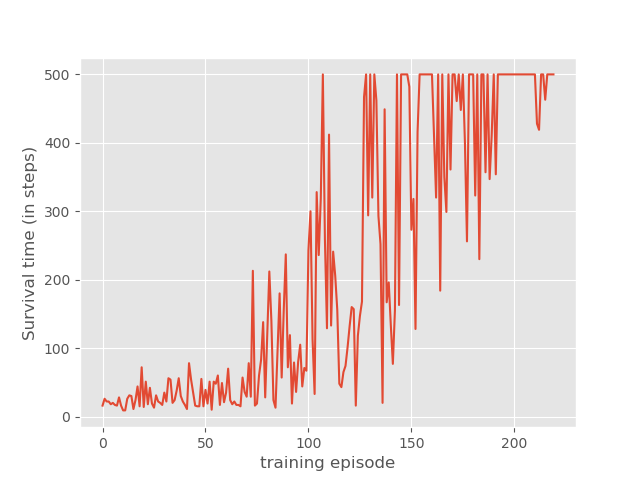

In [132]:
_, scores = solver.run()

plt.style.use('ggplot')
plt.figure()
plt.plot(scores)
plt.xlabel('training episode')
plt.ylabel('Survival time (in steps)')
plt.show()

In [133]:
solver.render()

# Outlook

- Introduction to Q-learning: step by step reasoning and intuition behind the algorithm
    - not just a 'black-box' that works

    
- Beyond Q-learning: modern Q-learning algorithms generally use various extension, but the core idea is the same
    A few example:
    
    - __Double Q-learning__: 
        - use of two Q functions to avoid maximization bias
    
    - __n-step bootstrapping__:
        - generalization of one-step Temporal-Difference methods to n-step (i.e. between TD and Monte Carlo)
    
    - __TD($\lambda$) and eligibility traces__:
        - use of 'short-term memory' 
        - kind of average of n-step methods for all n
        
         
- Vanilla Q-learning is a __tabular__ methods: the action-state value Q(s, a) is stored in memory for _all_ pairs: that can be a lot!
- Solution:
    - use function approximations,  $Q(s, a) \Rightarrow Q(s, a, \boldsymbol{\theta})$, with parameters $\boldsymbol{\theta}$. 
    - Update rule not on $Q(s, a)$ directly but on $\boldsymbol{\theta}$ $\Rightarrow$ supervised learning.
    - Use RL algorithm to obtain the targets used for training.
 
  
- __Deep Q-learning__:
    - Use a (deep) neural network to approximate Q
    - additional convergence problems $\rightarrow$ more complex algorithm (e.g. with experience replay)
    - Deadly triad: _function approximation, bootstrapping, and off-policy learning_

# The end